In [19]:
## Some of the code seems to require Python 3

import sys
sys.version
import os
directory_name = "/make_quantum_jump_trajectories/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)
    
import itertools
import build_markov
# from hmmlearn import hmm
import warnings
warnings.filterwarnings("ignore")
from imp import reload

%matplotlib inline
plt.style.use("ggplot")

## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

In [20]:
reload(build_markov)

<module 'build_markov' from '/Users/gil/Documents/repos/diffusion_maps/build_markov.py'>

In [21]:
from sample_systems import *

In [22]:
params = {alpha0 : 52.467, chi : -106.066, Delta : 750., kappa_1 : 220, kappa_2 : 1e-10,
          'Ntraj' : 1, 'duration' : 6000., 'Nfock' : 15}

In [36]:
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']

Tsim = np.arange(0, duration/1000, 1e-3)
delta_t = Tsim[1] - Tsim[0]

In [37]:
slh_kerr_qnet, a_qnet = make_kerr_slh(index = 1,which_symbols='qnet',params=params)

In [38]:
## multiple Kerr SLH
slh_driven_kerr = (slh_kerr_qnet << Displace(alpha=params[alpha0])+cid(1)).toSLH()

In [39]:
a = a_qnet[0]
single_kerr_obs = tuple([a.dag()*a, a+a.dag(), (a-a.dag())/1j])
single_kerr_obsq = [o.to_qutip(full_space=slh_kerr_qnet.space) for o in single_kerr_obs]

In [40]:
mcdata_driven_kerr = make_traj(slh_driven_kerr, Tsim, single_kerr_obsq)

100.0%. Run time:  21.88s. Est. time left: 00:00:00:00
Total run time:  21.93s


## Build Markov Model for system 1

In [41]:
dim_red= build_markov.dim_red_builder(Regime= "kerr_bistable",
                sample_type = 'all',
                mcdata = mcdata_driven_kerr,)

In [42]:
markov_builder = build_markov.markov_model_builder(dim_red)

In [121]:
markov_builder.build_model(n_clusters = 40,which_coords = 'expects')

converged True


### Original System 1

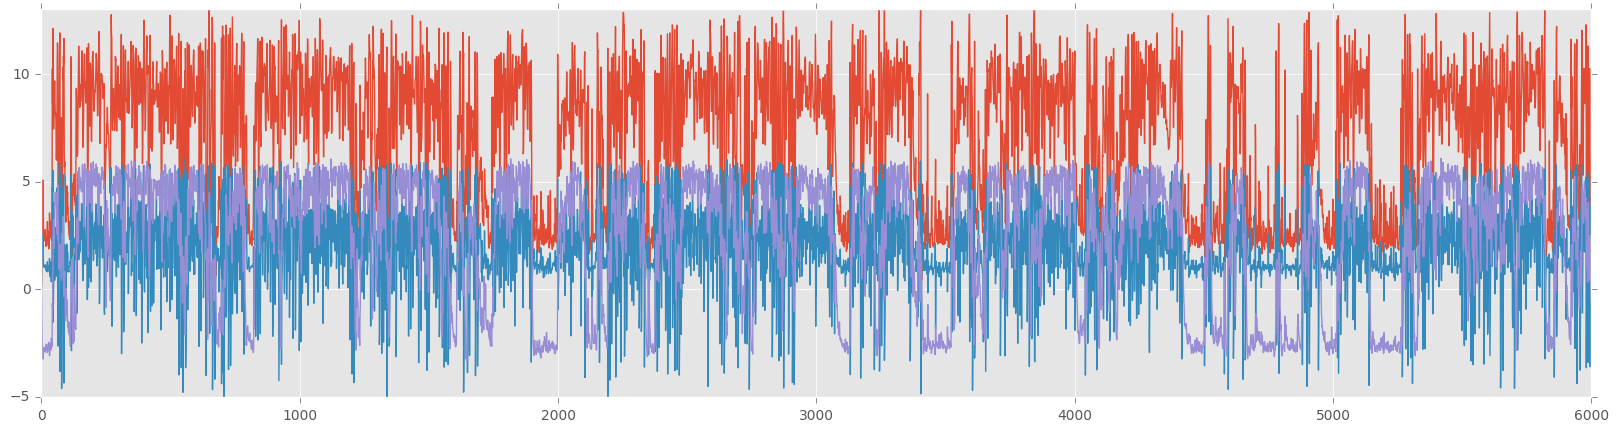

In [122]:
plt.figure(figsize=(20,5))
plt.plot(np.concatenate(mcdata_driven_kerr.expect[:6000]).T[:,:3]);
plt.ylim(-5,13);

### HMM for system 1 only

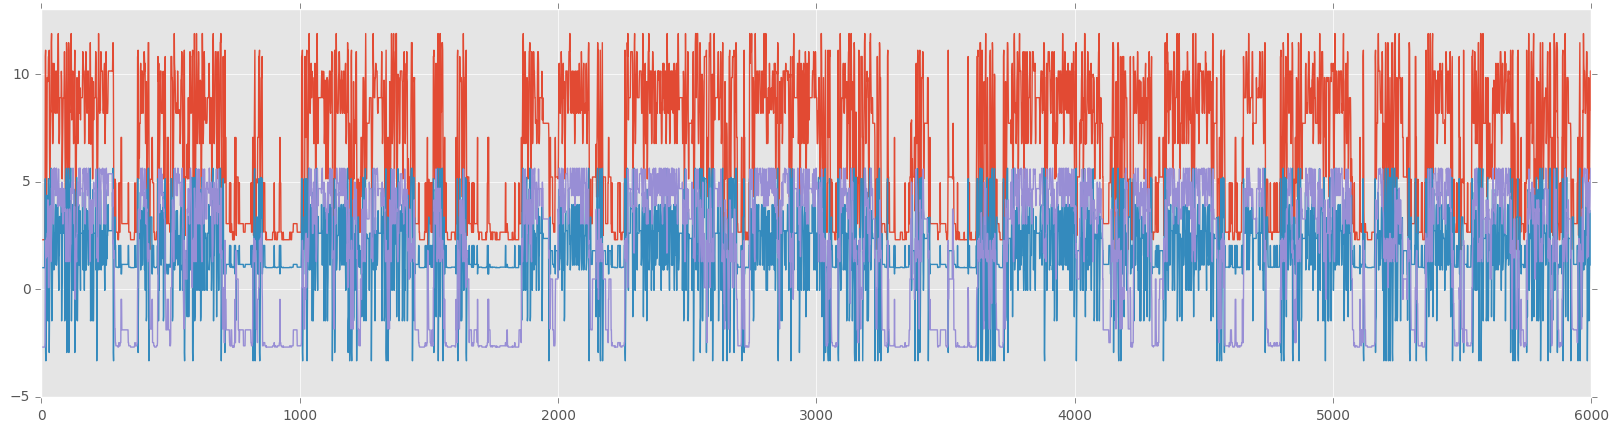

In [123]:
plt.figure(figsize=(20,5))
plt.plot(markov_builder.generate_obs_traj(6000).T);
plt.ylim(-5,13);

## Hybrid Model $S1 \to S2$

In [124]:
slh_kerr_sympy, sympy_symbols = make_kerr_slh(index = 0,which_symbols='sympy',params=params)

In [125]:
replacement_dict = {symbol : index for symbol, index in zip(sympy_symbols,range(3)) }

In [126]:
slh_12 = (slh_kerr_qnet << slh_kerr_sympy << Displace(alpha=params[alpha0])+cid(1)).toSLH()

In [127]:
slh_12

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-7.41619848709566*I*p - 7.41619848709566*x + 52.467, IdentityOperator), ScalarTimesOperator(2*sqrt(55), Destroy(LocalSpace('1', ''))))], [OperatorPlus(ScalarTimesOperator(-5.0e-6*I*p - 5.0e-6*x, IdentityOperator), ScalarTimesOperator(1.00000000000000e-5, Destroy(LocalSpace('1', ''))))]]), OperatorPlus(ScalarTimesOperator(-53.033*N*(N + 1) + 750.0*N, IdentityOperator), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(5.0e-11*I*p + 5.0e-11*x + 2*sqrt(55)*(7.41619848709566*I*p + 7.41619848709566*x), Create(LocalSpace('1', ''))), ScalarTimesOperator(-2*sqrt(55)*(-7.41619848709566*I*conjugate(p) + 7.41619848709566*conjugate(x)) + 5.0e-11*I*conjugate(p) - 5.0e-11*conjugate(x), Destroy(LocalSpace('1', ''))))), ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(52.467, OperatorPlus(ScalarTimesOperator(-7.41619848709566*I*p - 7.41619848709566*x, IdentityOperator), ScalarTimesOperator(2*sqrt(55), Destroy(Loca

In [128]:
hybrid = build_markov.hybrid_model(slh_12,markov_builder,replacement_dict,single_kerr_obsq,delta_t)

### Generating a sample trajectory for the hybrid system

In [129]:
Ntraj_12 = 1
hybrid.generate_trajectories(Tsim[:6000],Ntraj=Ntraj_12)

100.0%. Run time: 2900.86s. Est. time left: 00:00:00:00
Total run time: 2900.91s


In [130]:
sys_12_outputs = hybrid.get_generated_trajs()

In [131]:
obs_indices_12 = range(sys_12_outputs.shape[-1])

In [132]:
dim_red_12 = build_markov.dim_red_simple(Ntraj_12, sys_12_outputs, obs_indices_12, "sys_12_test")

In [133]:
markov_builder_12 = build_markov.markov_model_builder(dim_red_12)

In [ ]:
markov_builder_12.build_model(n_clusters = 40,which_coords = 'expects',covariance_type='spherical')

In [ ]:
sys_12_expects = markov_builder_12.generate_obs_traj(6000).T

### Can we build a Markov model from system 1+2?

### Original System 1

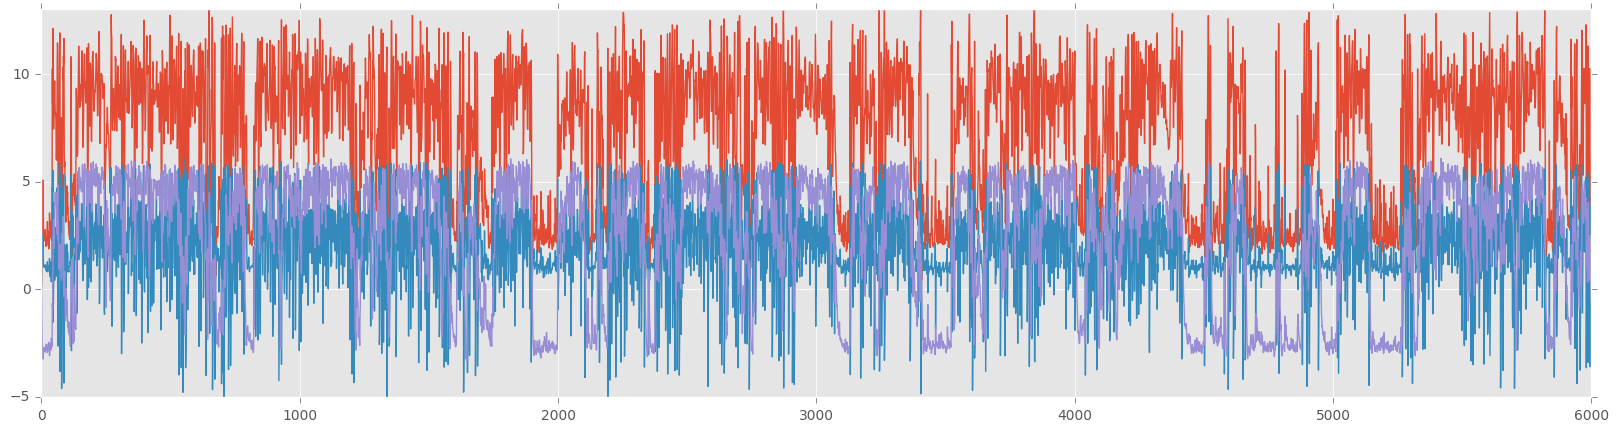

In [148]:
plt.figure(figsize=(20,5))
plt.plot(np.concatenate(mcdata_driven_kerr.expect[:6000]).T[:,:3]);
plt.ylim(-5,13);

### HMM for system 1 only

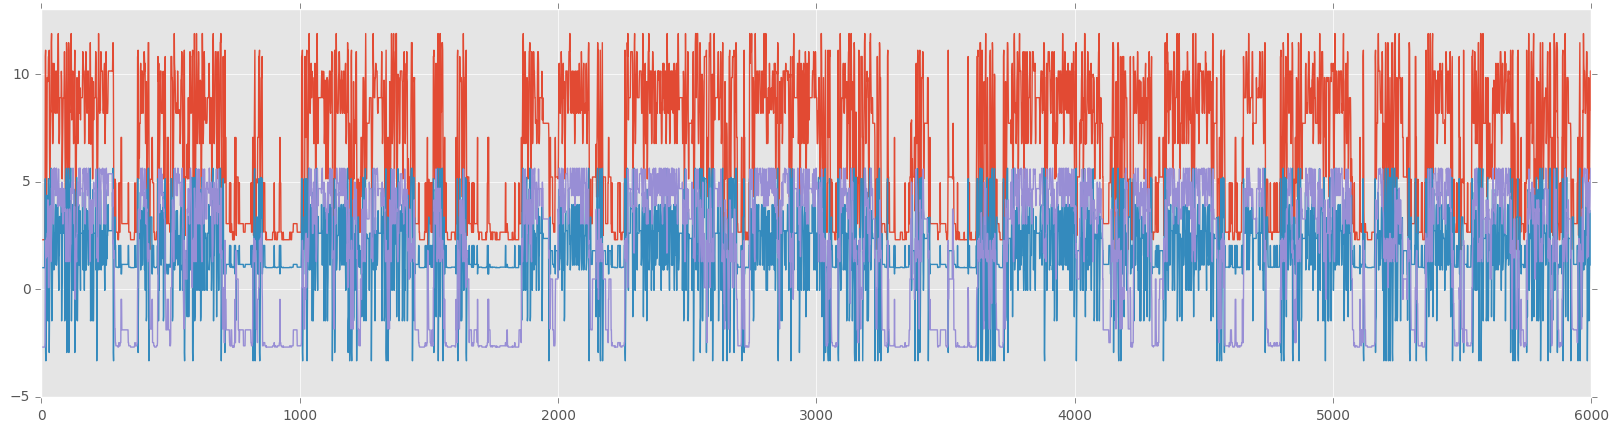

In [149]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_outputs[0,:,:3]);
plt.ylim(-5,13);

### Quantum system 2 with HMM inputs of system 1

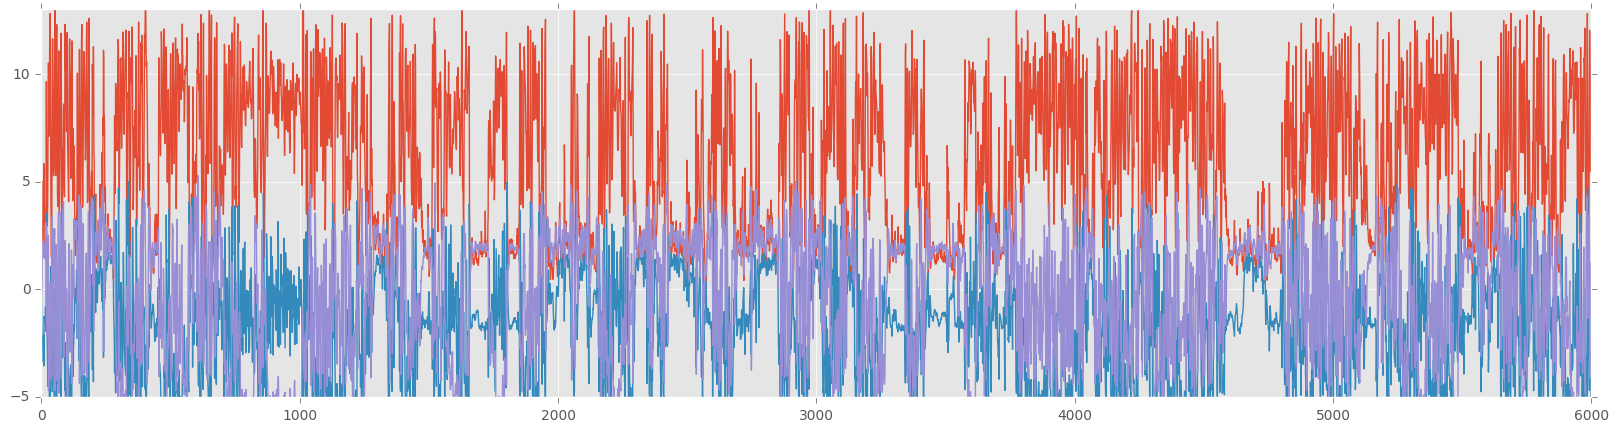

In [150]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_outputs[0,:,3:]);
plt.ylim(-5,13);

### System 1 observables from reduced system 1+2

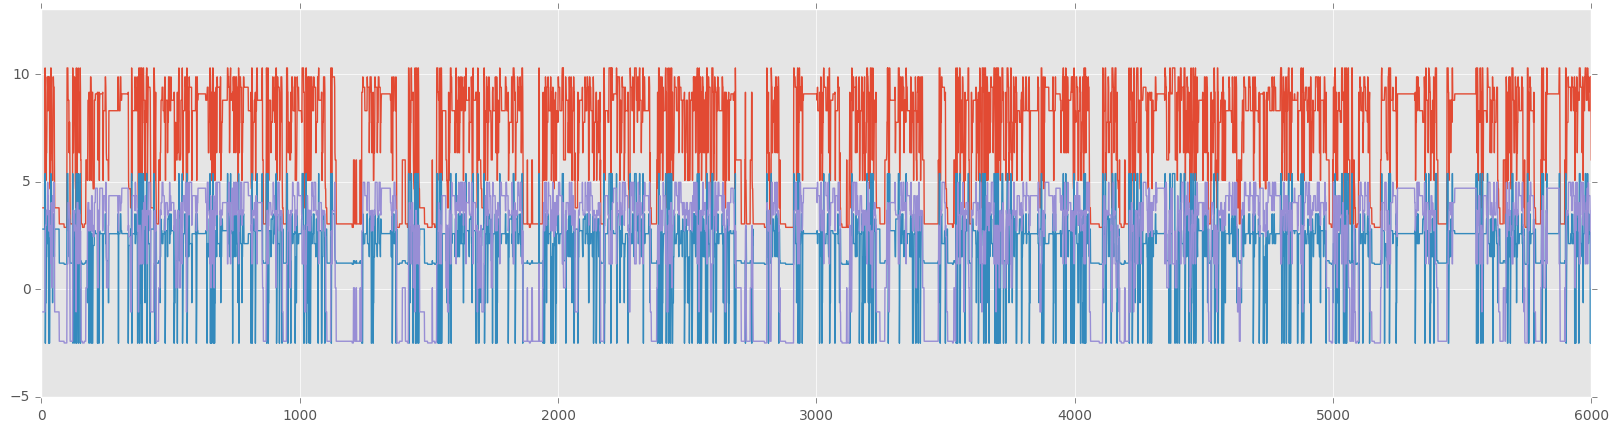

In [156]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_expects[:,:3]);
plt.ylim(-5,13);

### System 2 observables from reduced system 1+2

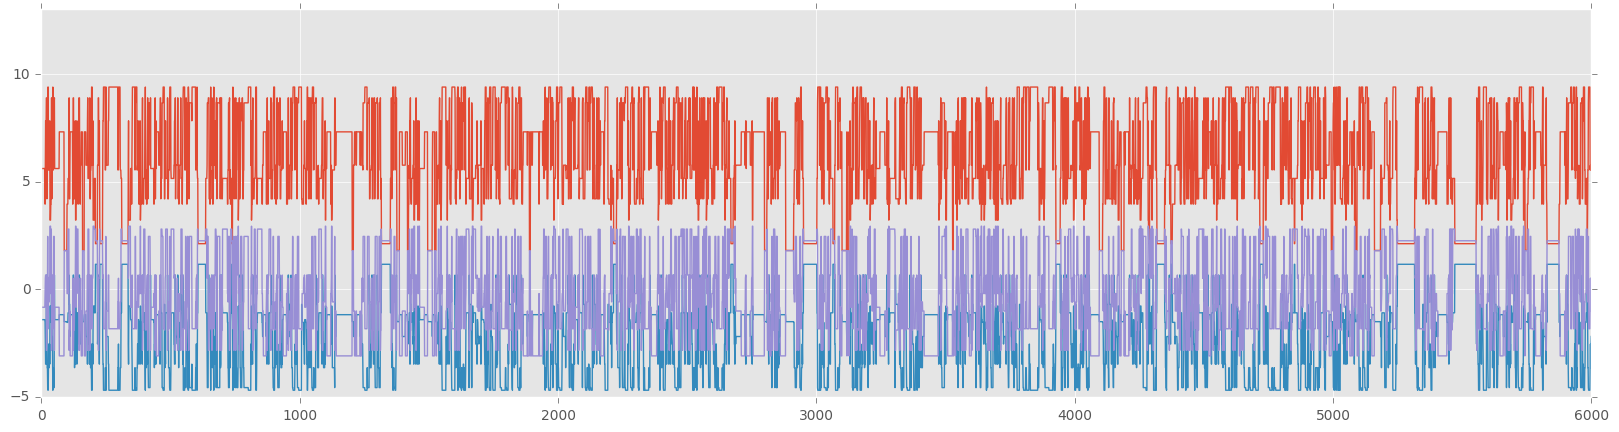

In [157]:
plt.figure(figsize=(20,5))
plt.plot(sys_12_expects[:,3:]);
plt.ylim(-5,13);

# Full system 1 + system 2

In [196]:
slh_kerr_qnet_1, a_1_lst = make_kerr_slh(index = 1,which_symbols='qnet',params=params)
slh_kerr_qnet_2, a_2_lst = make_kerr_slh(index = 2,which_symbols='qnet',params=params)

In [197]:
slh_12_full = (slh_kerr_qnet_2 << slh_kerr_qnet_1 << Displace(alpha=params[alpha0])+cid(1)).toSLH()

In [242]:
a1 = a_1_lst[0]
a2 = a_2_lst[0]
a_lst = [a1,a2]
two_kerr_obs = tuple(itertools.chain.from_iterable([[a.dag()*a, a+a.dag(), (a-a.dag())/1j ]  
           for a in a_lst]))
two_kerr_obsq = [o.to_qutip(full_space=slh_12_full.space) for o in two_kerr_obs]

In [243]:
expect_full_12 = np.asarray(make_traj(slh_12_full, Tsim, two_kerr_obsq).expect)

100.0%. Run time:  39.74s. Est. time left: 00:00:00:00
Total run time:  39.84s


In [244]:
expect_full_1, expect_full_2 = np.split(expect_full_12,2,axis=1)

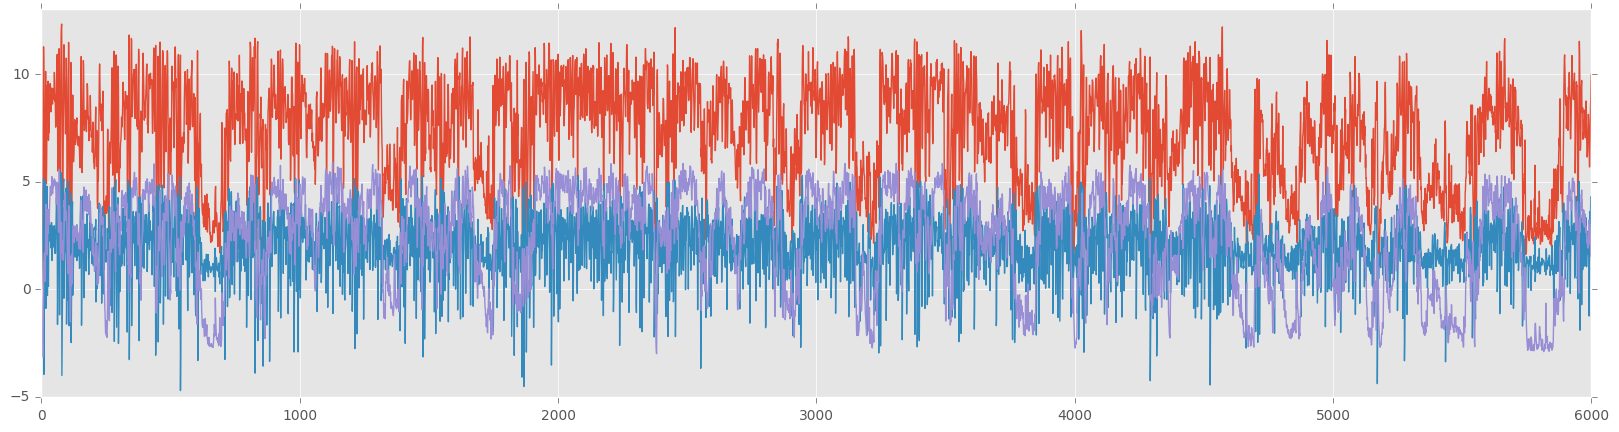

In [248]:
plt.figure(figsize=(20,5))
plt.plot(expect_full_1[0].T);
plt.ylim(-5,13);

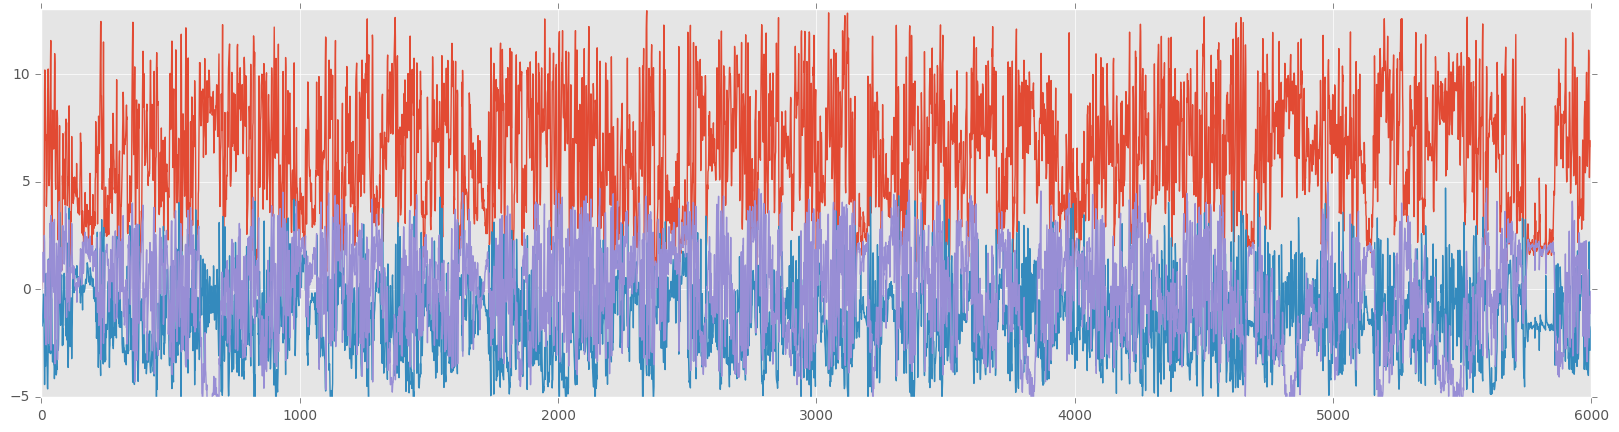

In [249]:
plt.figure(figsize=(20,5))
plt.plot(expect_full_2[0].T);
plt.ylim(-5,13);

## Comparing system 1 vs system 2 observables for reduced v. non-reduced 

In [169]:
from scipy.stats import gaussian_kde

In [179]:
## Plot density
def plot_density(x,y,s = 10):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=np.log(z), s=s, edgecolor='')

In [188]:
which_obs = 2  #### 0 -> N, 1 -> x, 2 -> p

### Full 1+2

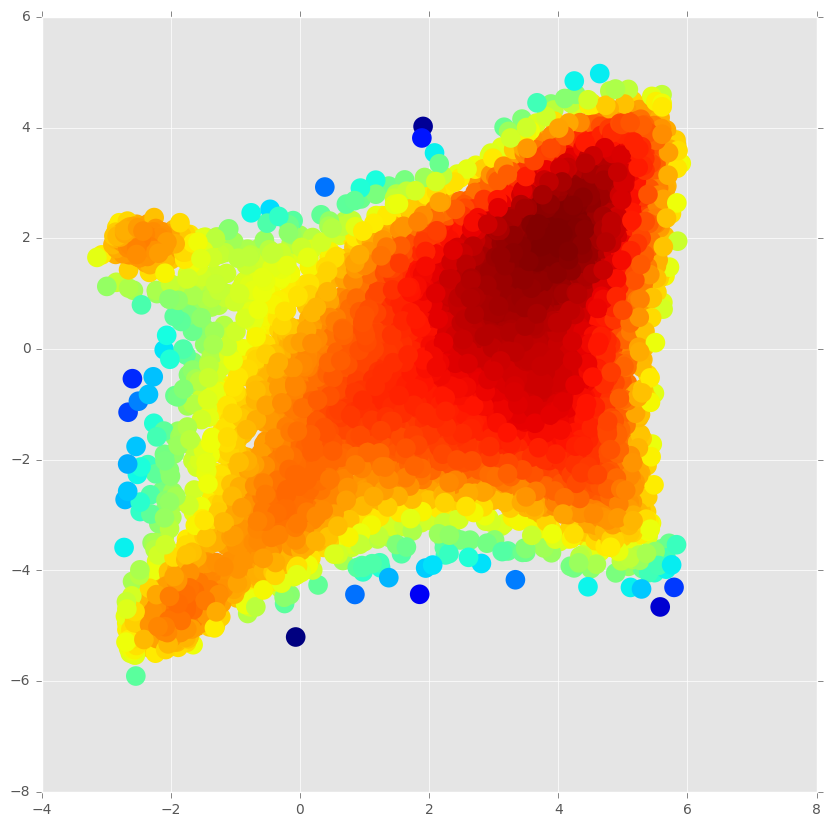

In [257]:
x,y = expect_full_1[0,which_obs,:],expect_full_2[0,which_obs,:]
plot_density(x,y,s = 200)

### Reduced 1 into 2

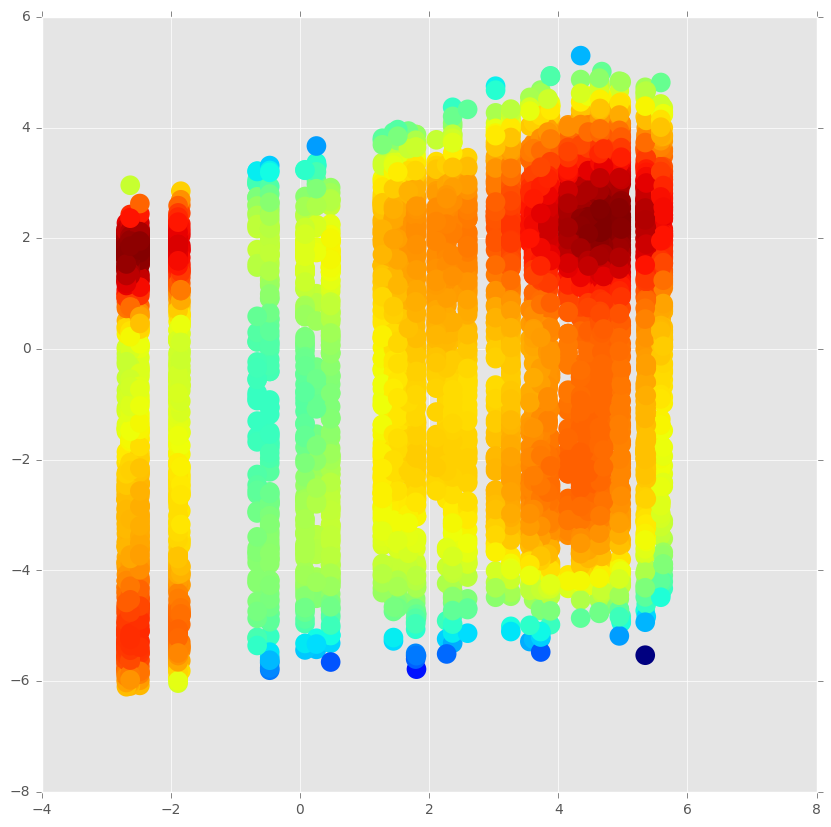

In [258]:
### Hybrid simulation
x,y = sys_12_outputs[0,:,which_obs], sys_12_outputs[0,:,3+which_obs]
plot_density(x,y,s = 200)

### Reduced (red(1)+2)

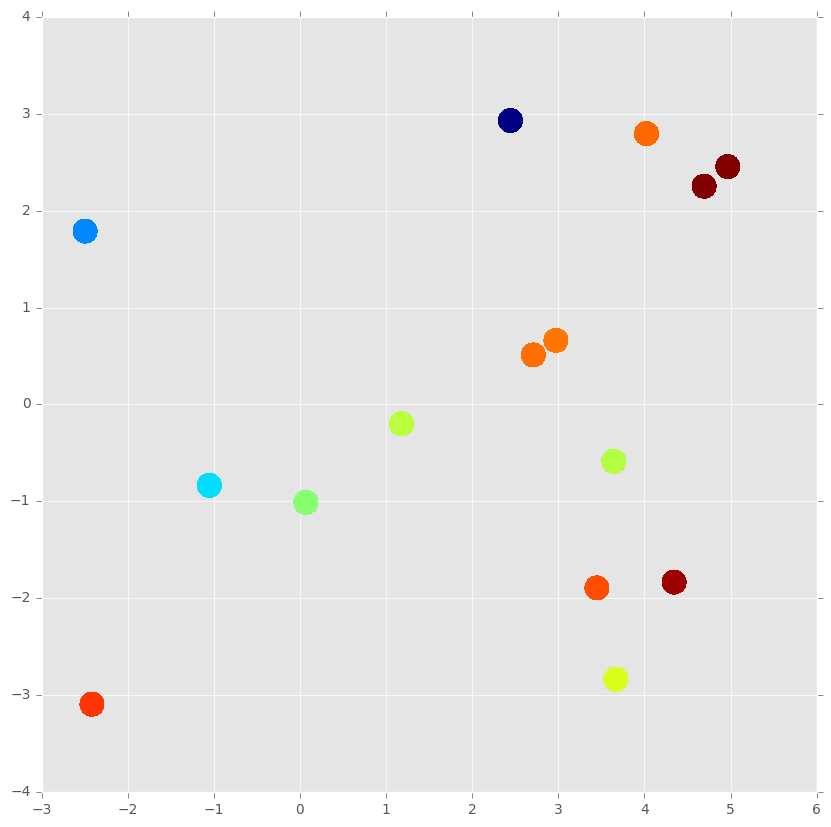

In [189]:
### Hybrid simulation
x,y = sys_12_expects[:,which_obs],sys_12_expects[:,3+which_obs]
plot_density(x,y,s = 300)

# Misc.

### Example on multiple trajs_per_generated_inputs.

In [28]:
hybrid.generate_trajectories(Tsim[:10],Ntraj=2,trajs_per_generated_inputs = 2)

50.0%. Run time:   0.26s. Est. time left: 00:00:00:00
100.0%. Run time:   0.29s. Est. time left: 00:00:00:00
Total run time:   0.33s
50.0%. Run time:   0.23s. Est. time left: 00:00:00:00
100.0%. Run time:   0.24s. Est. time left: 00:00:00:00
Total run time:   0.33s


In [29]:
sys_12_outputs = hybrid.get_generated_trajs()

In [30]:
sys_12_outputs.shape

(2, 2, 10, 6)

#### We find above a tensor of shape [l,i,j,k] Here these represent: 
            l: Fixing a trajectory of system 1, the index of the trajectory
                of system 2 with the fixed trajectory of system 1.
            i: which trajectory
            j: which timestep
            k: index of which expectation value. The expectation values of
                systems 1 and 2 are staked.